# Credit Card Fraud Detection

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from collections import Counter
import warnings
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

%matplotlib inline
np.random.seed(42)
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.3f}'.format
sns.set_style("whitegrid", {'axes.grid' : False})

## Initial Data Exploration

### Load Downloaded Data into dataframe

In [2]:
df = pd.read_csv("E:/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,...,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,...,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,...,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0
3,1.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,...,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.500,0
4,2.000,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,...,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.990,0


In [3]:
df.shape

(284807, 31)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

#### Our dataset have 284807 examples and 30 features + 1 target. As describe in the dataset, 28 features were generate by PCA and are confidencial (V1 - V28). 2 features we have information (Time and Amount). All features have data type of float64 and the target int64.


Total No of Fraud cases : (492, 31)
Total No of Normal cases : (284315, 31)


Text(0.5, 1.0, 'Distribution graph 0-Normal,1-Fraud')

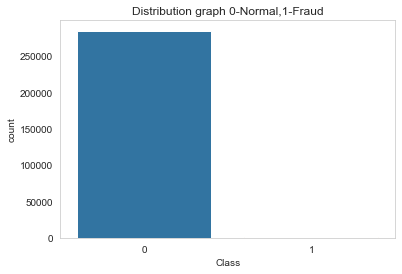

In [5]:
print("Total No of Fraud cases :",df[df['Class']==1].shape)
print("Total No of Normal cases :",df[df['Class']==0].shape)
sns.countplot('Class',data=df).set_title("Distribution graph 0-Normal,1-Fraud")

#### The dataset is very unbalanced

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.000,94813.860,47488.146,0.000,54201.500,84692.000,139320.500,172792.000
V1,284807.000,0.000,1.959,-56.408,-0.920,0.018,1.316,2.455
V2,284807.000,0.000,1.651,-72.716,-0.599,0.065,0.804,22.058
V3,284807.000,-0.000,1.516,-48.326,-0.890,0.180,1.027,9.383
V4,284807.000,0.000,1.416,-5.683,-0.849,-0.020,0.743,16.875
V5,284807.000,-0.000,1.380,-113.743,-0.692,-0.054,0.612,34.802
V6,284807.000,0.000,1.332,-26.161,-0.768,-0.274,0.399,73.302
V7,284807.000,-0.000,1.237,-43.557,-0.554,0.040,0.570,120.589
V8,284807.000,-0.000,1.194,-73.217,-0.209,0.022,0.327,20.007
V9,284807.000,-0.000,1.099,-13.434,-0.643,-0.051,0.597,15.595


#### Since we only know the information about the columns Time and Amount, we will first analyze those features to get some insight. The column Time we already know that contains the seconds elapsed between each transaction and the first transaction in the dataset. On the column Amount we can see some interesting things. There are transactions with the value 0 in Amount. The standard deviation is pretty high. So we need analyze more deep and we can do this observing that feature in Fraud and Not Fraud.

In [7]:
print('Amount [No Fraud]')
print(df.Amount[df['Class'] == 0].describe())
print('------------------------------')
print('Amount [Fraud]')
print(df.Amount[df['Class'] == 1].describe())

Amount [No Fraud]
count   284315.000
mean        88.291
std        250.105
min          0.000
25%          5.650
50%         22.000
75%         77.050
max      25691.160
Name: Amount, dtype: float64
------------------------------
Amount [Fraud]
count    492.000
mean     122.211
std      256.683
min        0.000
25%        1.000
50%        9.250
75%      105.890
max     2125.870
Name: Amount, dtype: float64


#### The value 0  appears in both classes

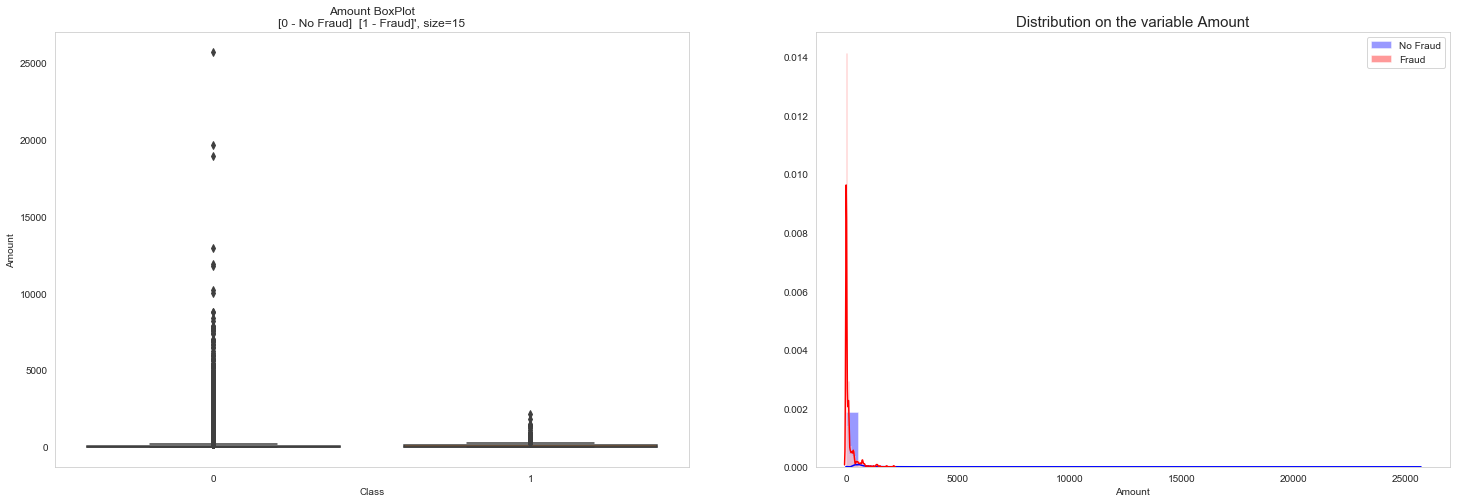

In [8]:
f, axes = plt.subplots(1, 2, figsize=(25,8))

sns.boxplot(x='Class', y='Amount', ax=axes[0], data=df).set_title("Amount BoxPlot\n[0 - No Fraud]  [1 - Fraud]', size=15")
sns.distplot(df.Amount[df['Class'] == 0], ax=axes[1], bins=50, label="No Fraud", color="b").set_title("Distribution on the variable Amount", size=15)
sns.distplot(df.Amount[df['Class'] == 1], ax=axes[1], bins=50, label="Fraud", color="r")
plt.legend()
plt.show()

#### We can notice here that are some extreme values on real transactions on the variable Amount. We can treat them as outlier, however, the model needs to learn the property of these high values and what make them real. It will be more robust if there was high values with fraud transactions too. Maybe, our model can be biased classifying every single high value as real transaction, but this kind of problem need to be treated in meetings. So, I decided to keep them.

In [9]:
print("Ocurrence of value 0 in the column Amount group by Class")
print(df.Amount.eq(0).astype(int).groupby(df.Class).sum())

Ocurrence of value 0 in the column Amount group by Class
Class
0    1798
1      27
Name: Amount, dtype: int32


#### There are 1798 occurrences of real transactions with value 0 and 27 occurrences of fraud transactions with value 0. Only a few observations, so, we can treated this as outlier and we can remove them.

In [10]:
df.drop(df.loc[df['Amount'] == 0].index, inplace=True)
df.shape

(282982, 31)

#### Now we will check the variable time

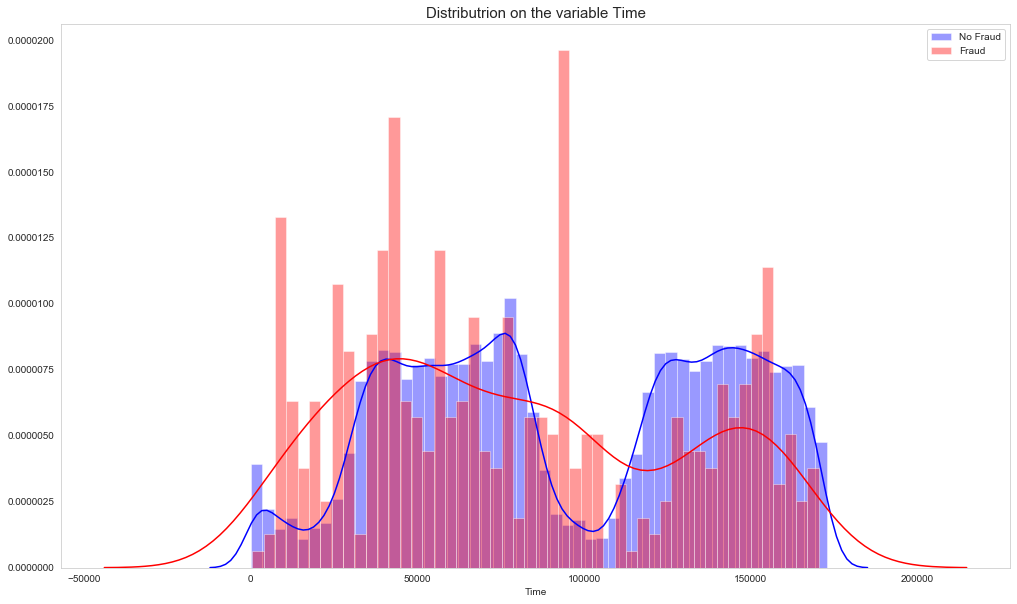

In [11]:
plt.figure(figsize=(17,10))
sns.distplot(df.Time[df['Class'] == 0], bins=50, label="No Fraud", color="b").set_title("Distributrion on the variable Time", size=15)
sns.distplot(df.Time[df['Class'] == 1], bins=50, label="Fraud", color="r")
plt.legend()
plt.show()


#### This variable don't give us enough information since contains only the seconds elapsed between each transaction. Now, let's check the anonymous variables generated by PCA

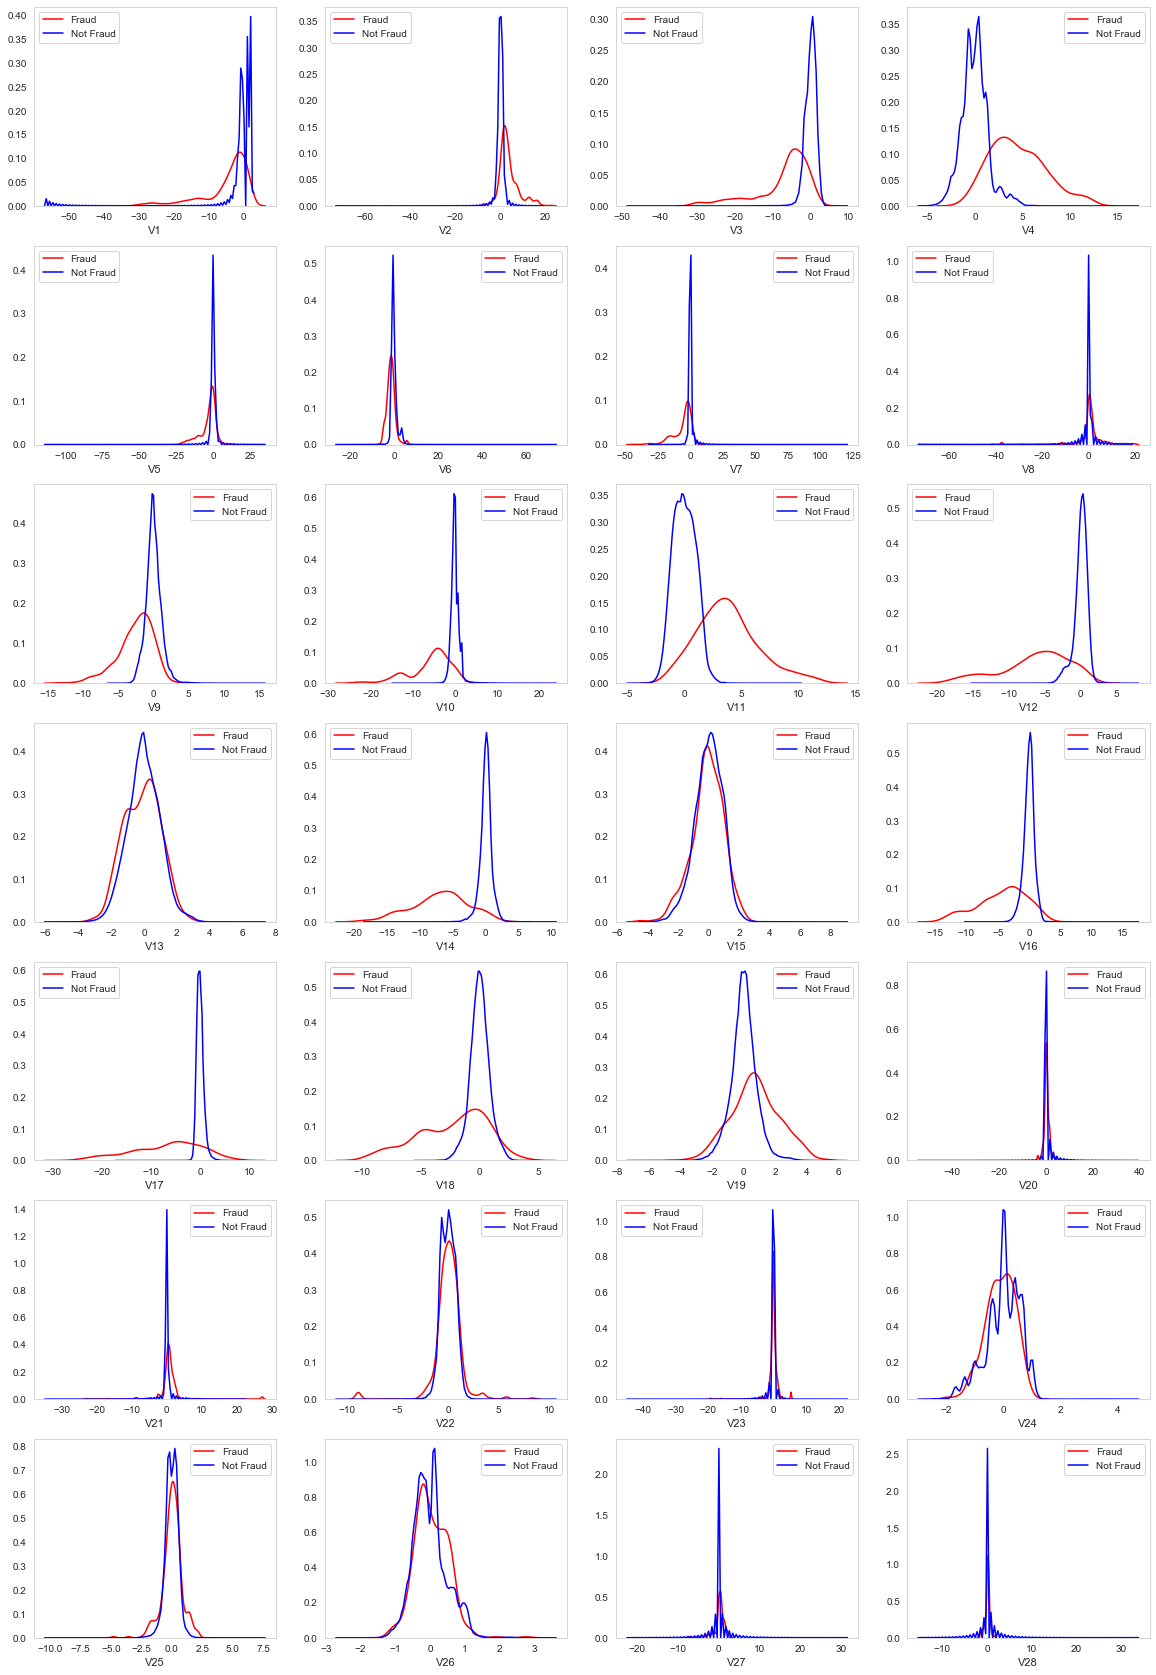

In [12]:
fig, ax = plt.subplots(7, 4, figsize=(20,30))

i = 0
for c in df.columns[1:-2]:
    i += 1
    plt.subplot(7, 4, i)
    sns.kdeplot(df.loc[df['Class'] == 1][c], label="Fraud", color="r")
    sns.kdeplot(df.loc[df['Class'] == 0][c], label="Not Fraud", color="b")
    plt.xlabel(c, fontsize=11)
plt.show()

#### We can note that are some distributions that can be separable do distinguish between Fraud and Not Fraud. But, we don't know what are those variables because they are anonymous.

#### Let's check the correlation coeficient. But first, we will rearrange the columns of our dataframe.

In [13]:
cols = list(df.columns.values)
cols.pop(cols.index('Time'))
cols.pop(cols.index('Amount'))
df = df[['Time', 'Amount'] + cols]

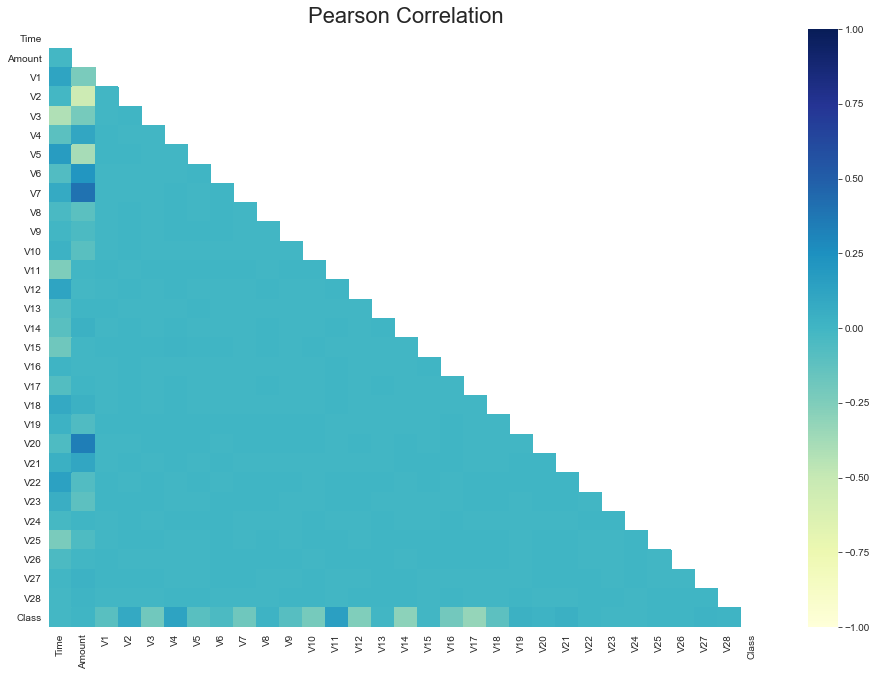

In [14]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(16,11))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1,  cmap="YlGnBu", xticklabels=corr.columns.values, yticklabels=corr.columns.values).set_title("Pearson Correlation", size=22)
plt.show()


#### From the correlation matrix we can observe that none of the anonymous variables have a correlation with each other, this can be explained by the fact that they were generated by the PCA algorithm. The Class variable has some positive (e.g. V11, V4, V2) and negative (e.g. V17, V14, V12) correlations between anonymous variables and no correlation with Amount.

## ETL

#### The dataset itself was provided by the kaggle and this notebook was made on the kaggle platform too. What we can do here is convert the dataframe to load into database for business usage.

In [15]:
from sqlalchemy import create_engine

engine = create_engine('sqlite://', echo=False)

In [16]:
df.to_sql('creditCardsTransactions', con=engine, if_exists='replace', index_label='id')
engine.execute('SELECT * FROM creditCardsTransactions LIMIT 1').fetchall()

[(0, 0.0, 149.62, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.33832076994251803, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.31116935369987897, 1.46817697209427, -0.47040052525947795, 0.20797124192924202, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.12853935827352803, -0.189114843888824, 0.13355837674038698, -0.0210530534538215, 0)]

## Feature Creation

#### The variables are all numerics. One thing we can do is work with the variable Time. Since the dataset was ocurred in two days, we can convert the seconds in hours between (0h - 23h) and remove the column Time. Let's do that.

In [17]:
df['Hours'] = np.ceil((df['Time']/3600).mod(24))
df.drop('Time',axis=1, inplace=True)

cols = list(df.columns.values)
cols.pop(cols.index('Hours'))
df = df[['Hours'] + cols]

df.head()

,Hours,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.000,149.620,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,...,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,0
1,0.000,2.690,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,...,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,0
2,1.000,378.660,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,...,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,0
3,1.000,123.500,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,...,-0.208,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,0
4,1.000,69.990,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,...,0.409,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,0


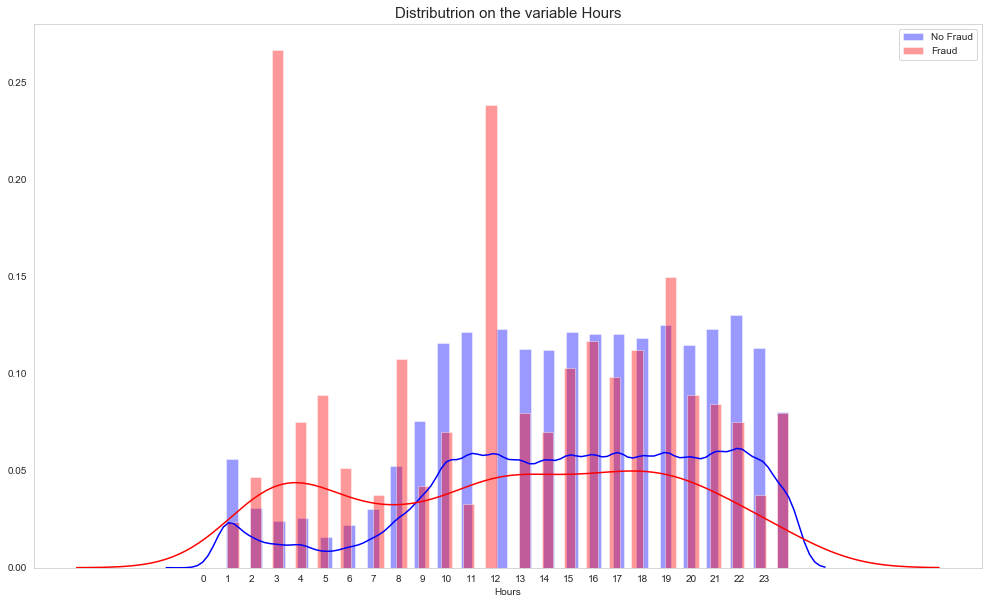

In [18]:
plt.figure(figsize=(17,10))
sns.distplot(df.Hours[df['Class'] == 0], bins=50, label="No Fraud", color="b").set_title("Distributrion on the variable Hours", size=15)
sns.distplot(df.Hours[df['Class'] == 1], bins=50, label="Fraud", color="r")
plt.xticks(range(0,24))
plt.legend()
plt.show()

#### Here we can observe there are more fraud ocurrences than real on dawn time. Let's maintain this column to our model.

### Data Preparation

In [19]:
# Original data
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

print('Train:', X_train.shape)
print('Test:', X_test.shape)
print('Target distribution on train:', Counter(y_train))
print('Target distribution on test:', Counter(y_test))

Train: (226385, 30)
Test: (56597, 30)
Target distribution on train: Counter({0: 226013, 1: 372})
Target distribution on test: Counter({0: 56504, 1: 93})


## Model Defination

### RandomForestClasifier and XGBClassifier

********************
RandomForestClassifier
Results:
Accuracy: 1.0
Precision: 0.96
Recall: 0.76
F1: 0.85
AUC: 0.97
********************
XGBClassifier
Results:
Accuracy: 1.0
Precision: 0.96
Recall: 0.79
F1: 0.86
AUC: 0.99


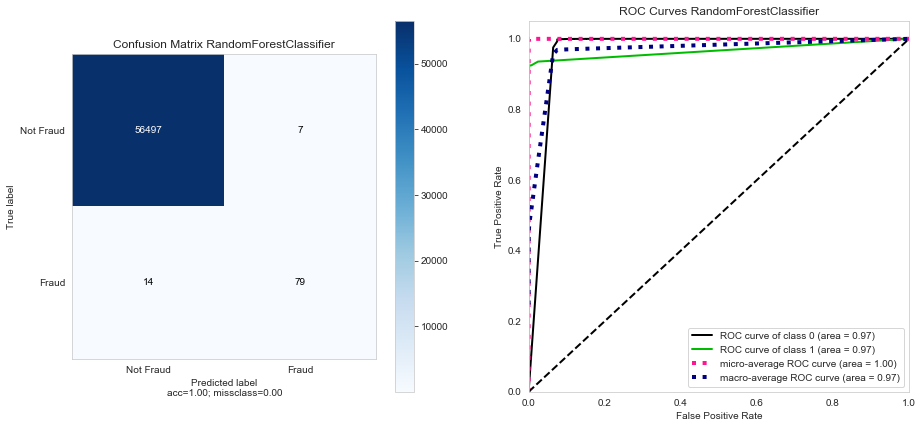

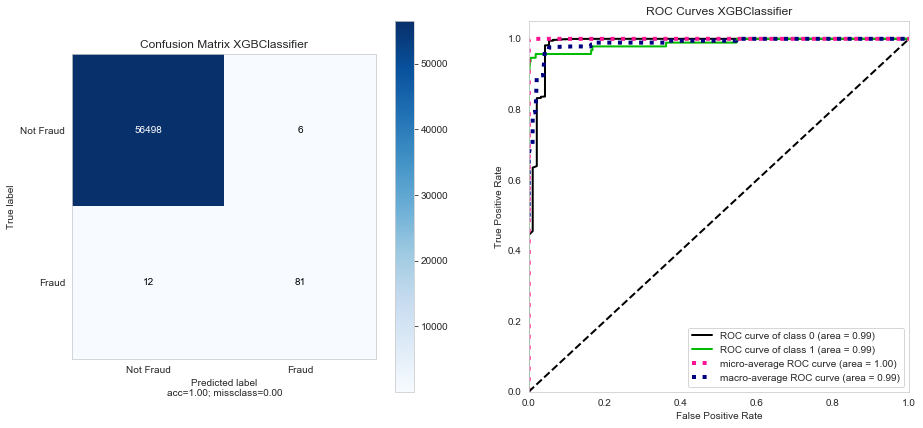

In [20]:
from sklearn.model_selection import cross_validate

classifiers = {
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBClassifier": XGBClassifier()
}

scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}

i = 0
for classifier in classifiers.values():
    i += 1
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    print("*"*20)
    print(classifier.__class__.__name__)
    print("Results:")
    scores = cross_validate(classifier, X_train, y_train, scoring=scoring, cv=5)
    print("Accuracy:", np.round(scores['test_accuracy'].mean(), 2))
    print("Precision:", np.round(scores['test_precision'].mean(), 2))
    print("Recall:", np.round(scores['test_recall'].mean(), 2))
    print("F1:", np.round(scores['test_f1'].mean(), 2))
    y_pred_proba = classifier.predict_proba(X_test)[::,1]
    auc = roc_auc_score(y_test, y_pred_proba)
    print("AUC:", np.round(auc, 2))
    
    plt.figure(figsize=(15,15))

    ax1 = plt.subplot(2, 2, i)
    i += 1
    skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=False, ax=ax1)
    ax1.set_yticklabels(['Not Fraud', 'Fraud'])
    ax1.set_xticklabels(['Not Fraud', 'Fraud']) 
    ax1.set_xlabel('Predicted label\nacc={:0.2f}; missclass={:0.2f}'.format(accuracy_score(y_test, predictions), 1 - accuracy_score(y_test, predictions)))
    ax1.set_title('Confusion Matrix {}'.format(classifier.__class__.__name__))

    y_probas = classifier.predict_proba(X_test)
    ax2 = plt.subplot(2, 2, i)
    skplt.metrics.plot_roc(y_test, y_probas, figsize=(10,8), ax=ax2)
    ax2.set_title('ROC Curves {}'.format(classifier.__class__.__name__))

In [22]:
from sklearn.model_selection import cross_validate

random_grid = {
    'max_depth': [2, 3, 5, 10, None],
    'n_estimators': [50, 100, 200, 500],
    "criterion": ["entropy", "gini"],
    "class_weight": [None, 'balanced']
}

clr_rf = RandomForestClassifier(random_state=42)
gs = RandomizedSearchCV(clr_rf, param_distributions=random_grid, n_iter=5, verbose=0, cv=5, scoring='roc_auc', random_state=42)
gs.fit(X_train, y_train)

print('RANDOM FOREST')
print("Best Score: {}".format(gs.best_score_))
print("Best Parameters: {}\n".format(gs.best_params_))

clr_rf = gs.best_estimator_

RANDOM FOREST
Best Score: 0.960561095168571
Best Parameters: {'n_estimators': 500, 'max_depth': 5, 'criterion': 'gini', 'class_weight': None}



In [25]:
random_grid = {
        'learning_rate' : [0.02, 0.1, 0.2, 0.3, 0.4],
        'n_estimators' : [50, 100, 200, 500],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [2, 3, 5, 10]
        }

clr_xgb = XGBClassifier(objective='binary:logistic', tree_method='hist', random_state=42)
gs = RandomizedSearchCV(clr_xgb, param_distributions=random_grid, n_iter=30, verbose=0, cv=5, scoring='roc_auc', random_state=42)
gs.fit(X_train, y_train)

print('XGBOOST')
print("Best Score: {}".format(gs.best_score_))
print("Best Parameters: {}\n".format(gs.best_params_))

clr_xgb = gs.best_estimator_




XGBOOST
Best Score: 0.9773056567632515
Best Parameters: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.2, 'gamma': 0.5}



********************
RandomForestClassifier
Results:
Accuracy: 1.0
Precision: 0.94
Recall: 0.7
F1: 0.8
AUC: 0.98
********************
XGBClassifier
Results:
Accuracy: 1.0
Precision: 0.94
Recall: 0.76
F1: 0.84
AUC: 0.99


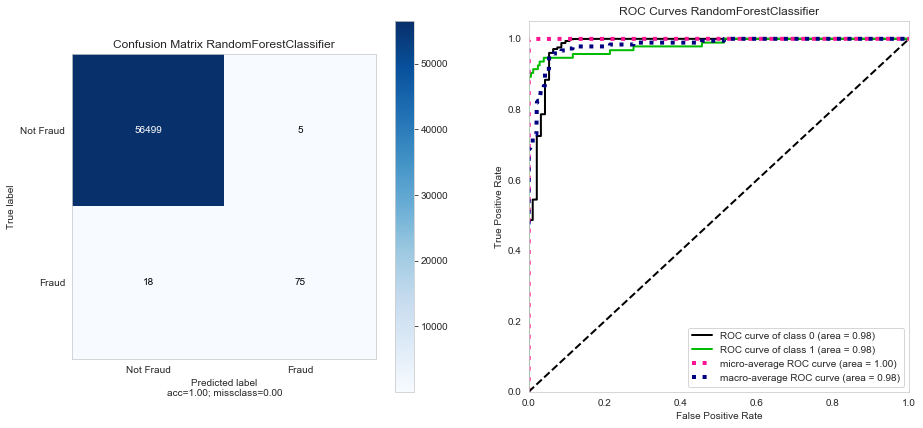

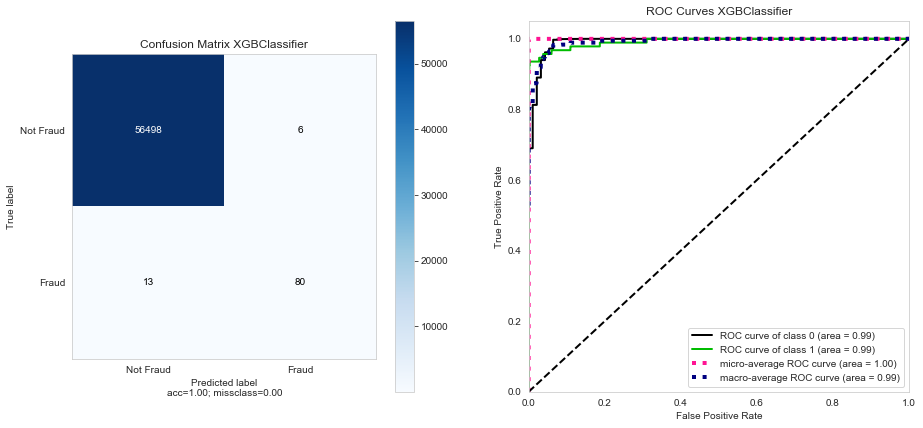

In [26]:
classifiers = {
    "RandomForestClassifier": clr_rf,
    "XGBClassifier": clr_xgb
}


scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}

i = 0
for classifier in classifiers.values():
    i += 1
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    print("*"*20)
    print(classifier.__class__.__name__)
    print("Results:")
    scores = cross_validate(classifier, X_train, y_train, scoring=scoring, cv=5)
    print("Accuracy:", np.round(scores['test_accuracy'].mean(), 2))
    print("Precision:", np.round(scores['test_precision'].mean(), 2))
    print("Recall:", np.round(scores['test_recall'].mean(), 2))
    print("F1:", np.round(scores['test_f1'].mean(), 2))
    y_pred_proba = classifier.predict_proba(X_test)[::,1]
    auc = roc_auc_score(y_test, y_pred_proba)
    print("AUC:", np.round(auc, 2))
    
    plt.figure(figsize=(15,15))

    ax1 = plt.subplot(2, 2, i)
    i += 1
    skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=False, ax=ax1)
    ax1.set_yticklabels(['Not Fraud', 'Fraud'])
    ax1.set_xticklabels(['Not Fraud', 'Fraud']) 
    ax1.set_xlabel('Predicted label\nacc={:0.2f}; missclass={:0.2f}'.format(accuracy_score(y_test, predictions), 1 - accuracy_score(y_test, predictions)))
    ax1.set_title('Confusion Matrix {}'.format(classifier.__class__.__name__))

    y_probas = classifier.predict_proba(X_test)
    ax2 = plt.subplot(2, 2, i)
    skplt.metrics.plot_roc(y_test, y_probas, figsize=(10,8), ax=ax2)
    ax2.set_title('ROC Curves {}'.format(classifier.__class__.__name__))

### Neural Network

In [34]:
def preprocessing_fnn(data):
    norm = (data - data.mean())/data.std()
    return norm

X_train_fnn = preprocessing_fnn(X_train)
X_test_fnn = preprocessing_fnn(X_test)

In [35]:
def model_fnn():
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(512, input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("relu"))
    #model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(256, kernel_initializer="he_normal", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("relu"))
    #model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(128, kernel_initializer="he_normal", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("relu"))
    #model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(64, kernel_initializer="he_normal", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("relu"))
    #model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(32, kernel_initializer="he_normal", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("relu"))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Nadam())
    
    return model

In [36]:
model_dl = model_fnn()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=10)
hist = model_dl.fit(X_train_fnn, y_train, batch_size=64, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Train on 181108 samples, validate on 45277 samples
Epoch 1/100
181108/181108 [==============================] - 23s 125us/sample - loss: 0.0239 - val_loss: 0.0039
Epoch 2/100
181108/181108 [==============================] - 22s 119us/sample - loss: 0.0046 - val_loss: 0.0043
Epoch 3/100
181108/181108 [==============================] - 22s 122us/sample - loss: 0.0043 - val_loss: 0.0204
Epoch 4/100
181108/181108 [==============================] - 23s 128us/sample - loss: 0.0041 - val_loss: 0.0036
Epoch 5/100
181108/181108 [==============================] - 23s 125us/sample - loss: 0.0040 - val_loss: 0.0033
Epoch 6/100
181108/181108 [==============================] - 23s 125us/sample - loss: 0.0039 - val_loss: 0.0035
Epoch 7/100
181108/181108 [==============================] - 23s 127us/sample - loss: 0.0037 - val_loss: 0.0095
Epoch 8/100
181108/181108 [==============================] - 23s 126us/sample - loss: 0.0036 - val_loss: 0.0047
Epoch 9/100
181108/181108 [==========================

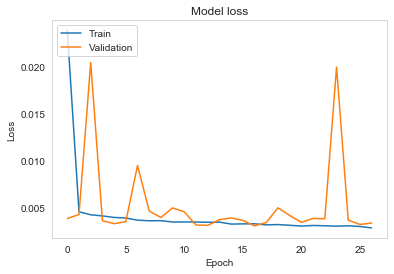

In [37]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [38]:
predictions = model_dl.predict_classes(X_test_fnn, verbose=0)

Text(0.5, 1.0, 'Confusion Matrix DL (Original data)')

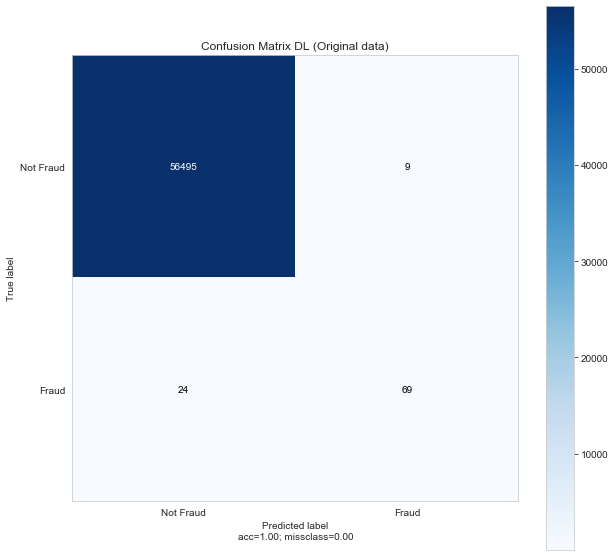

In [39]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(111)
skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=False, ax=ax1)
ax1.set_yticklabels(['Not Fraud', 'Fraud'])
ax1.set_xticklabels(['Not Fraud', 'Fraud']) 
ax1.set_xlabel('Predicted label\nacc={:0.2f}; missclass={:0.2f}'.format(accuracy_score(y_test, predictions), 1 - accuracy_score(y_test, predictions)))
ax1.set_title('Confusion Matrix DL (Original data)')

In [40]:
model_dl.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               15872     
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131072    
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              